In [1]:
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

pd.set_option('display.max_colwidth', 300)

# Read data
df = pd.read_pickle('Data\MovieSummaries\plots_genres_reduced_to_60.pkl')

# Preprocessing functions
def clean_text(text):
    text = re.sub("\'", "", text)
    text = re.sub("[^a-zA-Z]", " ", text)
    text = " ".join(text.split())
    text = text.lower()
    return text

def remove_stopwords(text):
    no_stop = []
    for i in text.split():
        if i not in stopwords:
            no_stop.append(i)
    return " ".join(no_stop)

def freq_plot(text):
    
    words = " ".join([x for x in text])
    words = words.split()
    fdist = nltk.FreqDist(words)
    return fdist



In [2]:
df.reset_index(inplace=True)
df

,index,id,text,title,genre
0,0,330,in order to prepare the role of an important old actress a theatre student interviews three actresses who were her pupils an international diva a television star and a dubbing director,Actrius,"[drama, comedydrama]"
1,1,3217,after being pulled through a time portal ash williams lands in ad where he is almost immediately captured by lord arthurs men who suspect him to be an agent for duke henry with whom arthur is at war he is enslaved along with the captured henry his gun and chainsaw confiscated and is taken to a c...,Army of Darkness,"[cult, horror, drama, actionadventure, fantasy, comedy, action]"
2,2,3333,the film follows two juxtaposed families the northern stonemans consisting of the abolitionist congressman austin stoneman his two sons and his daughter elsie and the southern camerons a family including two daughters margaret and flora and three sons most notably ben the stoneman brothers visi...,The Birth of a Nation,"[silent, indie, drama, blackandwhite, war]"
3,3,3746,hatnote in los angeles november retired police officer rick deckard is detained by officer gaff and brought to meet with his former supervisor bryant deckard whose job as a blade runner was to track down bioengineered beings known as replicants and retire them is told by bryant that several have...,Blade Runner,"[thriller, science fiction, cult, drama, noir, crime, chinese]"
4,4,3837,in the american old west of construction on a new railroad led by lyle runs into quicksand the route has to be changed which will require it to go through rock ridge a frontier town where everyone has the last name of johnson the conniving state attorney general hedley lamarr wants to buy the la...,Blazing Saddles,"[western, satire, comedy]"
...,...,...,...,...,...
41544,41788,37373877,according to horrorfest online six people with a common past converge years later at the funeral of an old friend while putting the affairs in order a map is presented to them they follow the directions to find a longlost time capsule from their youth the search is requested by the dead friend i...,Crazy Eights,"[cult, horror]"
41545,41789,37473592,thoppul kodihttpblogspotinthoppulkodihtml proclaims the pathetic life about the cylon refugees music done by music director thomas rathnamhttpwwwflipkartcomthoppulkodip he was also known as isai aruvi thomas rathnam he is an upcoming music composer from india he has done tamil films karuvarai po...,Thoppul Kodi,[drama]
41546,41790,37478048,anand verma a widower and father of a child admits a woman in the hospital who had lost her memory since he admitted her in the hospital the doctor asks him to take care of her until she recovers from amnesia the doctor names her asha which is the name of anands wife and makes her believe that s...,Mr. Bechara,[comedy]
41547,41791,37492363,when clovers childhood friend cherries returns to his hometown after a ten year separation he finds himself immediately attracted to her still outgoing spontaneous personality it isnt long before their rekindled friendship develops into a sweet quirky romance but as time passes and passions fade...,Cherries and Clover,"[comedy, drama, romance]"


In [3]:
#clean text
df["text"] = df["text"].apply(lambda x : clean_text(x))

# Get stopwords
from nltk.corpus import stopwords
#if stopwords not downloaded
#nltk.download('stopwords')
stopwords = set(stopwords.words("english"))
df["text"] = df["text"].apply(lambda x : remove_stopwords(x))

# Binarize genres
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_bina = MultiLabelBinarizer()
multilabel_bina.fit(df["genre"])
y = multilabel_bina.transform(df["genre"])

# TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(max_df= 0.8, max_features=10000)
xtrain, xval, ytrain, yval = train_test_split(df["text"], y, test_size = 0.2, random_state= 9)
xtrain_tfidf = tfidf_vect.fit_transform(xtrain)
xval_tfidf = tfidf_vect.transform(xval)

In [4]:
#make list aff all genre
genre_list = []
for i in range(len(df["genre"])):
    genre_list.append(df["genre"].iloc[i][0])

#unique genre
unique_genre = list(set(genre_list))
len(unique_genre)

57

In [5]:
# Documents Example with 5 Plots
documents = df["text"][0:5].reset_index(drop=True)

# Term Frequency-Inverse Document Frequency vectorizer
Tfid_vect = TfidfVectorizer()

# Transform the documents using the vectorizer
documents_vect = Tfid_vect.fit_transform(documents)

# Convert the transformed for better visability. Normally sparse matrix
#df = pd.DataFrame(documents_vect.toarray(), columns=Tfid_vect.get_feature_names_out())

#df

# Multi label logistic Regression

In [6]:

# Logistic Regression
logistic_mod = LogisticRegression()

# Separate binary classifier for each class label for multi-label classification
onevsall = OneVsRestClassifier(logistic_mod) 

# Train model
onevsall.fit(xtrain_tfidf, ytrain)

# Predict and evaluate
y_pred = onevsall.predict(xval_tfidf)
print(classification_report(yval, y_pred))

# Sample predictions
def new_val(x):  
    x = remove_stopwords(clean_text(x))
    x_vec = tfidf_vect.transform([x])
    x_pred = onevsall.predict(x_vec)
    return multilabel_bina.inverse_transform(x_pred)



              precision    recall  f1-score   support

           0       0.68      0.27      0.39      1126
           1       0.70      0.13      0.22       719
           2       0.00      0.00      0.00       229
           3       0.63      0.15      0.24       632
           4       0.86      0.29      0.43       514
           5       0.00      0.00      0.00        58
           6       0.00      0.00      0.00       108
           7       0.00      0.00      0.00       115
           8       0.00      0.00      0.00        60
           9       0.82      0.10      0.17       783
          10       0.00      0.00      0.00        59
          11       0.64      0.06      0.11       233
          12       0.00      0.00      0.00       125
          13       0.00      0.00      0.00       156
          14       0.85      0.24      0.37       196
          15       0.72      0.45      0.55      2534
          16       0.00      0.00      0.00       247
          17       0.00    

c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
#write classification report to csv
report = classification_report(yval, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('Results\Metrics\classification_report_reduced_to_60.csv', index=True, sep=';')

c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", df['title'][k], "\nPredicted genre: ", new_val(xval[k]))
    print("Actual genre: ",df['genre'][k], "\n")

Movie:  Protocol 
Predicted genre:  [('drama',)]
Actual genre:  ['political', 'comedy'] 

Movie:  Woody Dines Out 
Predicted genre:  [('animation', 'comedy', 'family', 'short')]
Actual genre:  ['short', 'family', 'comedy', 'animation'] 

Movie:  The 14 Amazons 
Predicted genre:  [('drama', 'war')]
Actual genre:  ['adventure', 'war', 'actionadventure', 'martial arts', 'drama', 'action'] 

Movie:  The Girl with the Dragon Tattoo 
Predicted genre:  [('crime', 'drama', 'thriller')]
Actual genre:  ['thriller', 'drama'] 

Movie:  Sagar alias Jackie 
Predicted genre:  [('action',)]
Actual genre:  ['action'] 



In [9]:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", df['title'][k], "\nPredicted genre: ", new_val(xval[k]))
    print("Actual genre: ",df['genre'][k], "\n")

Movie:  The ChubbChubbs! 
Predicted genre:  [()]
Actual genre:  ['childrensfamily', 'animation', 'short', 'comedy', 'childrens'] 

Movie:  White Line Fever 
Predicted genre:  [('drama',)]
Actual genre:  ['crime', 'action', 'drama'] 

Movie:  The Monster That Challenged the World 
Predicted genre:  [()]
Actual genre:  ['science fiction', 'horror', 'creature', 'blackandwhite'] 

Movie:  Om darbadar 
Predicted genre:  [('drama',)]
Actual genre:  ['thriller', 'comedy'] 

Movie:  The Motorcycle Diaries 
Predicted genre:  [('drama',)]
Actual genre:  ['indie', 'war', 'drama', 'biopic feature', 'coming of age', 'biographical', 'adventure'] 



In [10]:
for i in range(5): 
    print(k)
    k = xval.sample(1).index[0] 
    print("Movie: ", df['title'][k], "\nPredicted genre: ", new_val(xval[k]))
    print("Actual genre: ",df['genre'][k], "\n")

2844
Movie:  The Weight of Water 
Predicted genre:  [('drama',)]
Actual genre:  ['crime', 'thriller', 'indie', 'psychological thriller', 'mystery', 'period piece', 'drama', 'suspense', 'adaptation'] 

17732
Movie:  Foxy by Proxy 
Predicted genre:  [('animation', 'comedy', 'family', 'short')]
Actual genre:  ['short', 'animation'] 

29803
Movie:  Searchers 2.0 
Predicted genre:  [()]
Actual genre:  ['drama', 'comedy', 'indie'] 

33464
Movie:  Killer Flick 
Predicted genre:  [('comedy',)]
Actual genre:  ['thriller', 'crime', 'indie', 'action', 'actionadventure', 'satire', 'comedy'] 

14502
Movie:  Just Before Dawn 
Predicted genre:  [('horror',)]
Actual genre:  ['thriller', 'horror', 'slasher'] 



In [11]:
for i in range(5): 
    print(k)
    k = xval.sample(1).index[0] 
    print("Movie: ", df['title'][k], "\nPredicted genre: ", new_val(xval[k]))
    print("Actual genre: ",df['genre'][k], "\n")

18737
Movie:  Police! 
Predicted genre:  [('comedy',)]
Actual genre:  ['short', 'silent', 'indie', 'blackandwhite', 'comedy'] 

6761
Movie:  Rabbit Fire 
Predicted genre:  [('animation', 'comedy', 'family', 'short')]
Actual genre:  ['short', 'family', 'comedy', 'animation'] 

3995
Movie:  Down with Love 
Predicted genre:  [('comedy', 'romance')]
Actual genre:  ['comedy', 'parody', 'period piece', 'romance'] 

3122
Movie:  Ajnabee 
Predicted genre:  [('drama', 'romance')]
Actual genre:  ['romance', 'drama'] 

18591
Movie:  Deterrence 
Predicted genre:  [('political', 'thriller')]
Actual genre:  ['thriller', 'actionadventure', 'mystery', 'drama', 'political', 'action'] 



In [12]:
#Apply it to all Film
f = pd.DataFrame(xval)
f['generated_genre'] = pd.DataFrame(xval)['text'].apply(new_val)
f= f.merge(df, left_index=True, how='left', right_index=True).reset_index(drop=True)
f.head(10)

,text_x,generated_genre,index,id,text_y,title,genre
0,movie opens appears another average day hoagies alley top cat gang today posing boy scouts good deeds hopes getting rewards course benny ball saves life bag lady unbeknownst benny revealed afterwards actually rich woman named gertrude vandergelt plans leave fortune missing niece amy meanwhile of...,"[(comedy, crime)]",16941,9257011,movie opens appears another average day hoagies alley top cat gang today posing boy scouts good deeds hopes getting rewards course benny ball saves life bag lady unbeknownst benny revealed afterwards actually rich woman named gertrude vandergelt plans leave fortune missing niece amy meanwhile of...,Top Cat and the Beverly Hills Cats,"[comedy, animation]"
1,yearold annie parker living perfect young life loved especially mother father older sister none knows something horrible stalking perfect family fall afternoon young annie hears noise upstairs mother collapsed died agonizing downward spiral begins interweave story another far away brilliant rese...,"[(drama,)]",39936,33687379,yearold annie parker living perfect young life loved especially mother father older sister none knows something horrible stalking perfect family fall afternoon young annie hears noise upstairs mother collapsed died agonizing downward spiral begins interweave story another far away brilliant rese...,Decoding Annie Parker,[drama]
2,two brothers discuss positive negative aspects adultery mother lies beside coma brother r mi attempts discourage conversations become explicit time passes,"[(drama,)]",23365,15510725,two brothers discuss positive negative aspects adultery mother lies beside coma brother r mi attempts discourage conversations become explicit time passes,Les 3 P'tits Cochons,"[family, comedydrama, comedy]"
3,five people englishwoman evelyn wingate american reporter jonathan clark chinese peasant su tan german physicist klaus bechner soviet soldier ivan godofsky plucked everyday lives transported spacecraft confronted humanoid referring alien arnold moss explains representative world orbiting sun go ...,"[(science fiction, thriller)]",4529,1613385,five people englishwoman evelyn wingate american reporter jonathan clark chinese peasant su tan german physicist klaus bechner soviet soldier ivan godofsky plucked everyday lives transported spacecraft confronted humanoid referring alien arnold moss explains representative world orbiting sun go ...,The 27th Day,[science fiction]
4,descendant impoverished polish noble family young wokulski forced work waiter hopfers warsaw restaurant dreaming life science taking part failed uprising tsarist russia sentenced exile siberia eventual return warsaw becomes salesman mincels haberdashery marrying late owners widow comes money use...,"[(comedy, drama)]",33251,26409391,descendant impoverished polish noble family young wokulski forced work waiter hopfers warsaw restaurant dreaming life science taking part failed uprising tsarist russia sentenced exile siberia eventual return warsaw becomes salesman mincels haberdashery marrying late owners widow comes money use...,The Doll,"[romance, drama]"
5,film centers mike halligan retired cop suffers fatal heart attack putting christmas lights days christmas heaven makes deal return life days order fulfill promise take grandson new york city holidays,"[(drama,)]",38357,32104837,film centers mike halligan retired cop suffers fatal heart attack putting christmas lights days christmas heaven makes deal return life days order fulfill promise take grandson new york city holidays,It Came Upon the Midnight Clear,"[family, drama, television]"
6,dance tells story two teenagers irlan isabela pursue dreams becoming professional ballet dancers way escape violent slums rio de janeiro,"[(drama,)]",33350,26501265,dance tells story two teenagers irlan isabela pursue dreams becoming professional ballet dancers way escape violent slums rio de janeiro,Only When I Dance,[documentary]
7,pink panthers picnic gets rui

## Multilabel classification confusion matrix with MLCM Paper function

In [13]:
#clean lists
for i in range(len(f["generated_genre"])):
    f["generated_genre"][i] = [x for x in f["generated_genre"][i][0]]

#sort lists in genre alphabetically
f["genre"] = f["genre"].apply(lambda x: sorted(x))


###prepare for library

# Create a set 
unique_genre = set()
for genres in f["genre"]:
    unique_genre.update(genres)
unique_genre = list(unique_genre)

#one-hot encoding 
one_hot_true = [[1 if genre in movie_genres else 0 for genre in unique_genre] for movie_genres in f["genre"]]
one_hot_pred = [[1 if genre in movie_genres else 0 for genre in unique_genre] for movie_genres in f["generated_genre"]]

#arrays
label_true = np.array(one_hot_true)
label_pred = np.array(one_hot_pred)

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_5188\1953526594.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f["generated_genre"][i] = [x for x in f["generated_genre"][i][0]]


### MLCM Library with minor changes in code

In [14]:
#Numpy Version problems solved
from mlcm_changed import mlcm

c:\Users\Gabriel\OneDrive\Dokumente\GitHub\NLP_Project\mlcm_changed\mlcm.py:206: RuntimeWarning: invalid value encountered in divide
  precision = tp/(tp+fp)
c:\Users\Gabriel\OneDrive\Dokumente\GitHub\NLP_Project\mlcm_changed\mlcm.py:207: RuntimeWarning: invalid value encountered in divide
  recall = tp/(tp+fn)



       class#     precision        recall      f1-score        weight

            0          0.50          0.21          0.30          1461
            1          0.53          0.13          0.20          759
            2          nan          0.00          0.00          58
            3          0.79          0.07          0.13          153
            4          0.33          0.00          0.01          288
            5          0.60          0.08          0.14          442
            6          0.75          0.00          0.01          789
            7          0.00          0.00          0.00          131
            8          0.45          0.25          0.32          1333
            9          nan          0.00          0.00          165
            10          nan          0.00          0.00          129
            11          nan          0.00          0.00          65
            12          nan          0.00          0.00          119
            13          0.71     

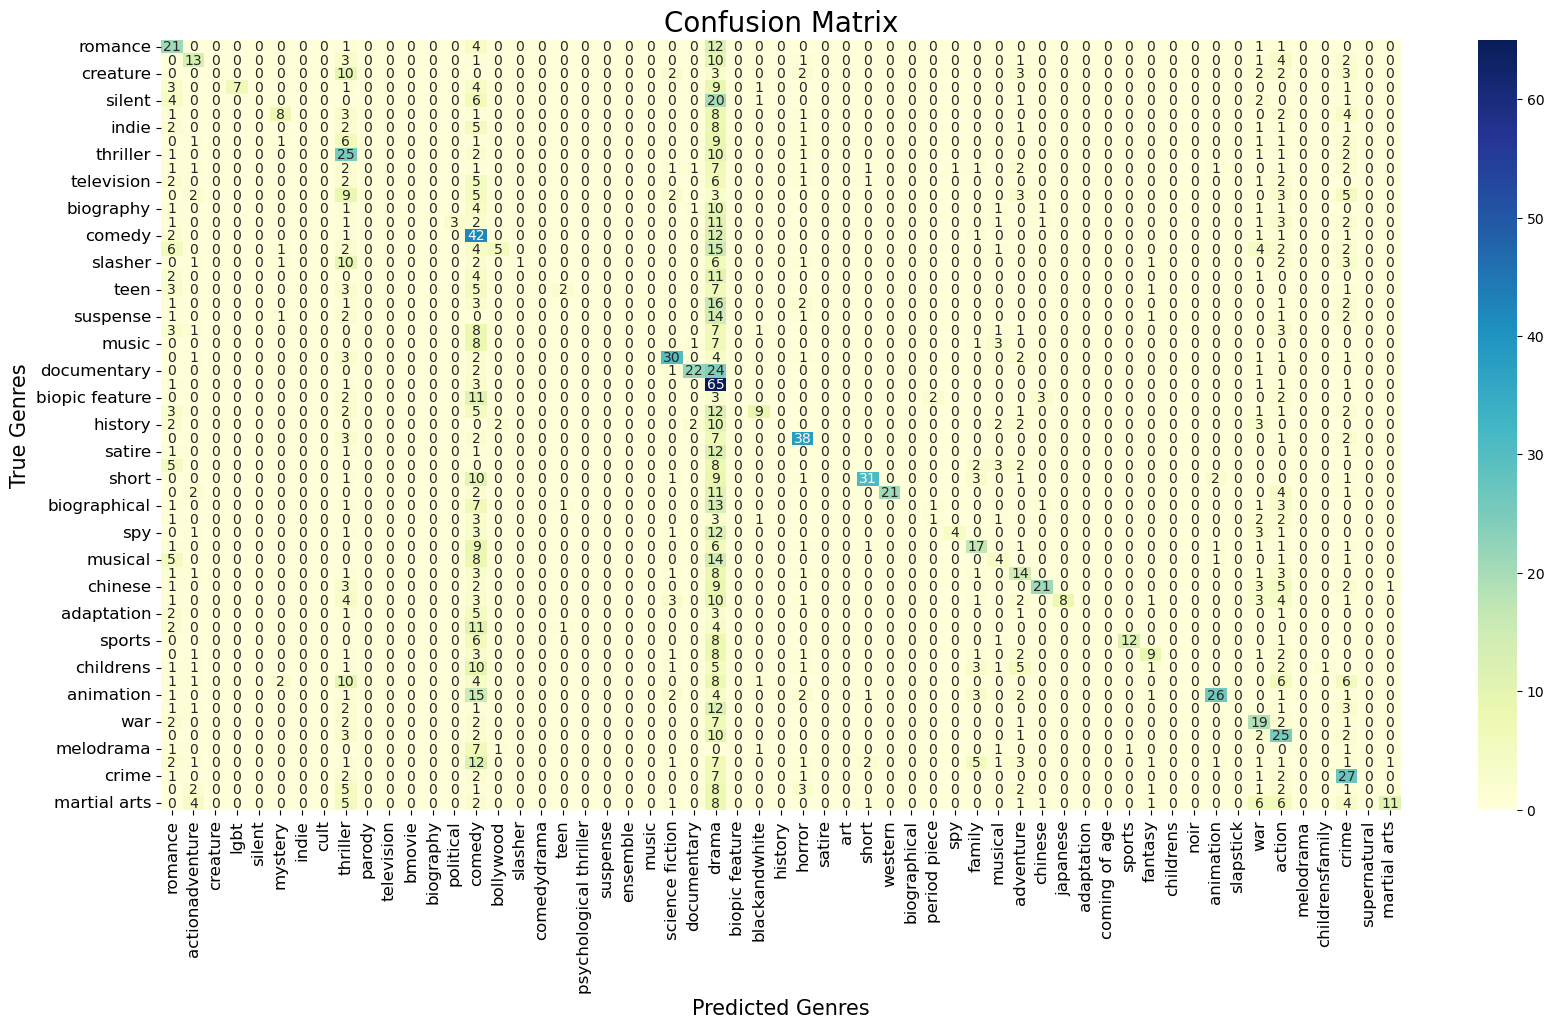

In [15]:
conf_mat,normal_conf_mat = mlcm.cm(label_true,label_pred,False)

one_vs_rest = mlcm.stats(conf_mat,False)

colnames = unique_genre + ['NPL']
rownames = unique_genre + ['NTL']


#make dataframe from confusion matrix
df_confusion = pd.DataFrame(normal_conf_mat, columns=colnames, index=rownames)
df_confusion.drop('NTL', inplace=True)
df_confusion.drop('NPL', axis=1, inplace=True)

#plot df_confusion
plt.figure(figsize = (20,10))
sns.heatmap(df_confusion, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Genres', fontsize=15)
plt.ylabel('True Genres', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

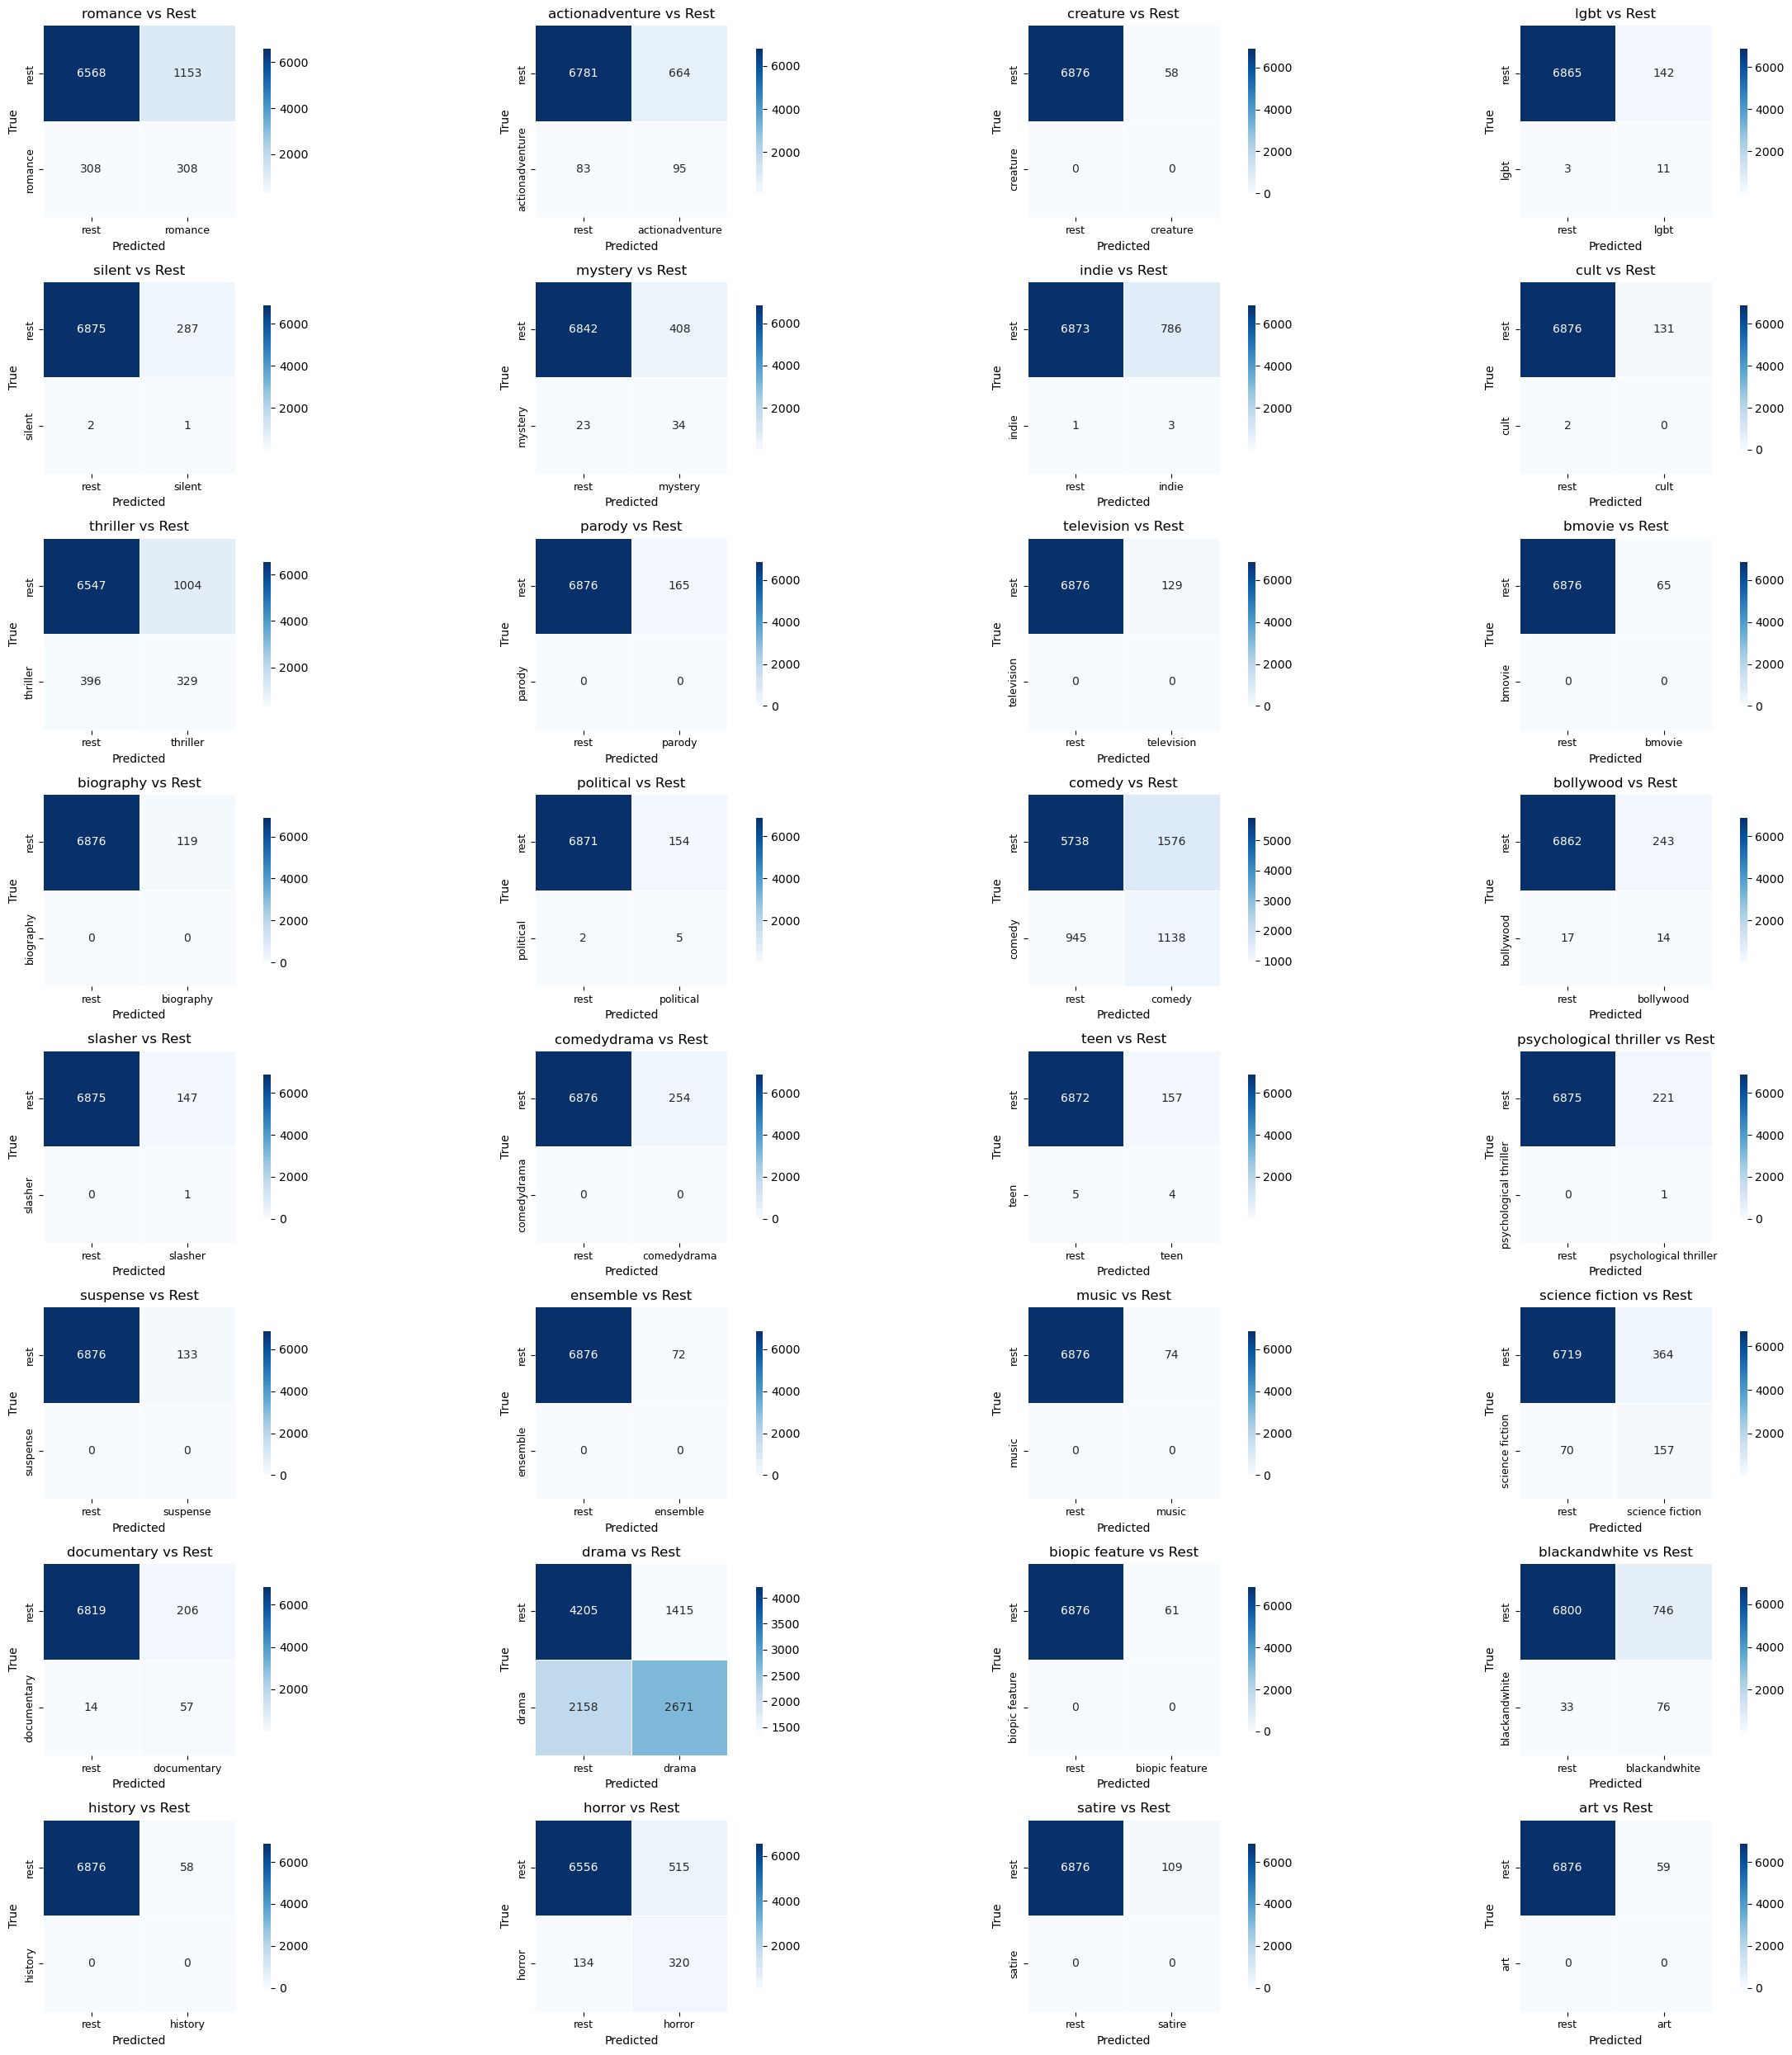

In [23]:

plt.figure(figsize=(25, 25))


n=32
#  first n
for i in range(n):  
    #column names
    colnames = ['rest', unique_genre[i]]
    
    #DataFrame
    df1 = pd.DataFrame(one_vs_rest[i], columns=colnames, index=['rest' , unique_genre[i]]).transpose()

    ax = plt.subplot(int(n/4), 4, i + 1)
    
    #heatmap
    sns.heatmap(df1, annot=True, fmt="d", cmap="Blues", square=True, linewidths=.5, cbar_kws={"shrink": .75})

    # Titles and labels
    ax.set_title(f'{unique_genre[i]} vs Rest', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('True', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=9)

plt.tight_layout()
plt.show()


SVM

In [ ]:
#do state vector machine
import sklearn.svm as svm
from sklearn.multiclass import OneVsRestClassifier

# Create a classifier: a support vector classifier
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=0))

# Train the classifier on the training set
classifier.fit(xtrain_tfidf, ytrain)

# Predict and evaluate
y_pred = classifier.predict(xval_tfidf)
print(classification_report(yval, y_pred))

# Sample predictions
def new_val(x):  
    x = remove_stopwords(clean_text(x))
    x_vec = tfidf_vect.transform([x])
    x_pred = classifier.predict(x_vec)
    return multilabel_bina.inverse_transform(x_pred)

In [ ]:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", df['title'][k], "\nPredicted genre: ", new_val(xval[k]))
    print("Actual genre: ",df['genre'][k], "\n")

Naive Bayes

In [ ]:
# do with naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier

# Create a classifier: a support vector classifier
classifier = OneVsRestClassifier(GaussianNB())

# Train the classifier on the training set
classifier.fit(xtrain_tfidf.toarray(), ytrain)

# Predict and evaluate
y_pred = classifier.predict(xval_tfidf.toarray())
print(classification_report(yval, y_pred))

# Sample predictions
def new_val(x):  
    x = remove_stopwords(clean_text(x))
    x_vec = tfidf_vect.transform([x])
    x_pred = classifier.predict(x_vec.toarray())
    return multilabel_bina.inverse_transform(x_pred)

In [ ]:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", df['title'][k], "\nPredicted genre: ", new_val(xval[k]))
    print("Actual genre: ",df['genre'][k], "\n")